# AR(2) model with variational inference

In [15]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import jax.random as random
import jax.example_libraries.optimizers as optimizers

from gaul import advi

import matplotlib.pyplot as plt
import arviz

plt.rcParams['figure.figsize'] = (11, 7)

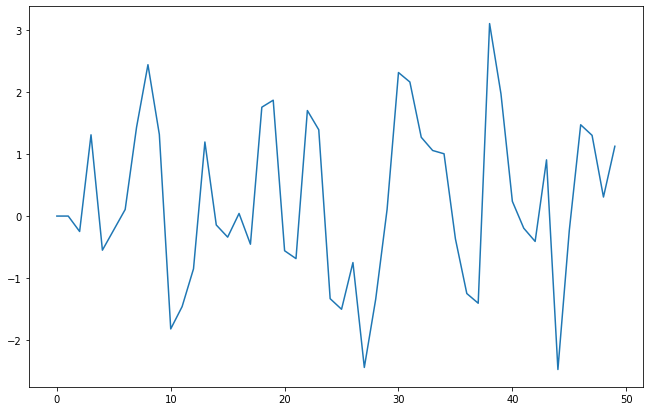

In [16]:
n = 50
beta1 = 0.5
beta2 = -0.3
sigma = 1.3

y = jnp.zeros(n)
for i in range(2, n):
    y = y.at[i].set(beta1 * y[i - 1] + beta2 * y[i - 2] + sigma * random.normal(random.PRNGKey(i)))

plt.plot(y)

In [4]:
def ln_posterior(params, data):
    target = 0
    
    target += stats.norm.logpdf(params['beta1'], 0., 1.)
    target += stats.norm.logpdf(params['beta2'], 0., 1.)
    target += stats.expon.logpdf(jnp.exp(params['logstd']), scale=1.)
    
    target += stats.norm.logpdf(
        params['beta1'] * data['y'][1:-1] + params['beta2'] * data['y'][2:],
        data['y'][:-2], 
        jnp.exp(params['logstd'])
    ).sum()

    return target.sum()

In [5]:
params = dict(
    beta1=jnp.zeros(1),
    beta2 = jnp.zeros(1),
    logstd=jnp.zeros(1),
)

data = dict(
    y=y,
)

In [6]:
samples = advi.sample(
    ln_posterior,
    params,
    lr=0.2,
    data=data
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:
samples = jax.tree_util.tree_map(lambda x: x.reshape(-1), samples)

array([[<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>],
       [<AxesSubplot:title={'center':'logstd'}>,
        <AxesSubplot:title={'center':'logstd'}>]], dtype=object)

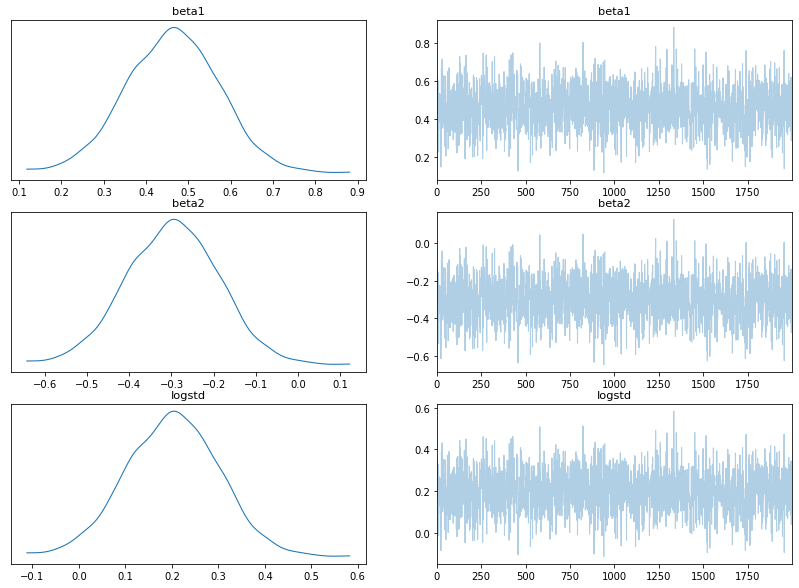

In [20]:
arviz.plot_trace(samples, figsize=(14, 10))

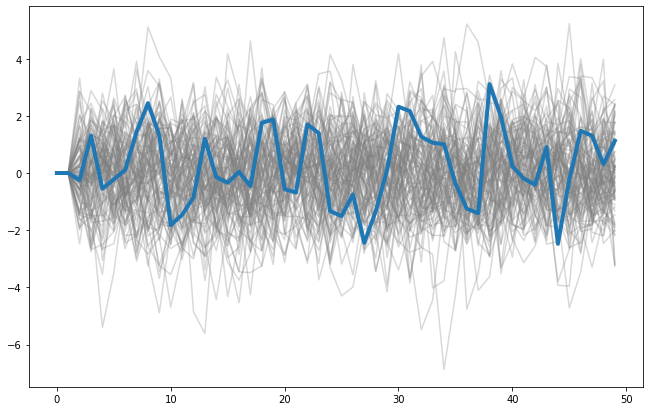

In [18]:
def sim_ar2(beta1, beta2, sigma, rng):
    ysim = jnp.zeros(n)
    for i in range(2, n):
        rng, subkey = random.split(rng)
        ysim = ysim.at[i].set(beta1 * ysim[i - 1] + beta2 * ysim[i - 2] + sigma * random.normal(subkey))
    return ysim

ysim = jax.vmap(sim_ar2)(
    samples['beta1'], 
    samples['beta2'], 
    jnp.exp(samples['logstd']), 
    random.split(random.PRNGKey(0), 2000)
)

for i in range(100):
    plt.plot(ysim[i], c='grey', alpha=0.3)
plt.plot(y, lw=4)